In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Para modelo
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

## Importación de data CSV 
Importación como un dataframe de pandas

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Por simplicidad, la variable objetivo(a predecir) será math_score.

## Preparando variables dependientes

In [ ]:
X = df.drop(columns=['math_score'], axis=1)

#axis=0: Drops rows (default behavior).
#axis=1: Drops columns.

In [5]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [6]:
y = df['math_score']

In [7]:
y.head()

0    72
1    69
2    90
3    47
4    76
Name: math_score, dtype: int64

Separaremos las variables numéricas de las categóricas de el dataframe X y transformaremos las variables con OneHotEndoder (para las variables categóricas) y StandarScaler(para las variables numéricas)

In [ ]:
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', oh_transformer, cat_features), # Aplica one-hot a columnas categóricas
        ('StandardScaler', numeric_transformer, num_features) # Aplica escalado estándar a columnas numéricas

    ]
)

In [9]:
X = preprocessor.fit_transform(X)

In [11]:
X.shape

(1000, 19)

In [13]:
# Separando dataset entre train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.shape, X_test.shape 



((800, 19), (200, 19))

### Funciones para obtención de métricas

In [14]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, r2_square

# MAE: promedio de errores absolutos; mide desviación media sin penalizar grandes errores
# MSE: promedio de errores al cuadrado; penaliza más los errores grandes
# RMSE: raíz cuadrada del MSE; mantiene unidades originales y resalta errores grandes
# R²: proporción de varianza explicada por el modelo; 1 es perfecto, 0 es sin mejora


In [16]:
# Diccionario con modelos de regresión a evaluar
models = {
    "Linear Regression": LinearRegression(), # Regresión lineal clásica
    "Lasso": Lasso(), # Regresión con regularización L1
    "Ridge": Ridge(), # Regresión con regularización L2
    "K-Neighbors Regressor": KNeighborsRegressor(), # Predicción basada en vecinos más cercanos
    "Decision Tree": DecisionTreeRegressor(), # Árbol de decisión 
    "Random Forest Regressor": RandomForestRegressor(),  # Ensamble 
    "XGBRegressor": XGBRegressor(), # Boosting basado en gradiente
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),  # Boosting optimizado para variables categóricas
    "AdaBoost Regressor": AdaBoostRegressor() # Boosting adaptativo
}

model_list = []
r2_list =[]

# Itera sobre cada modelo en el diccionario:
for i in range(len(list(models))):
    model = list(models.values())[i] # Extrae el modelo actual
    model.fit(X_train, y_train) # Entrena el modelo con datos de entrenamiento

    # Predicciones sobre entrenamiento y prueba
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test) 
    
    # Evalúa métricas de train
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    # Evalúa métricas en prueba
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    # Imprime nombre del modelo
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i]) # Guarda nombre del modelo
    
    # Métricas del conjunto de entrenamiento
    print('Performance del modelo para el conjunto de entrenamiento')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Performance del modelo para conjunto de test')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2) # Guarda R² de test
    
    print('='*35)
    print('\n')

Linear Regression
Performance del modelo para el conjunto de entrenamiento
- Root Mean Squared Error: 28.4675
- Mean Absolute Error: 4.2574
- R2 Score: 0.8755
----------------------------------
Performance del modelo para conjunto de test
- Root Mean Squared Error: 28.0801
- Mean Absolute Error: 4.1920
- R2 Score: 0.8791


Lasso
Performance del modelo para el conjunto de entrenamiento
- Root Mean Squared Error: 43.5236
- Mean Absolute Error: 5.1811
- R2 Score: 0.8096
----------------------------------
Performance del modelo para conjunto de test
- Root Mean Squared Error: 37.5922
- Mean Absolute Error: 4.9571
- R2 Score: 0.8381


Ridge
Performance del modelo para el conjunto de entrenamiento
- Root Mean Squared Error: 28.3577
- Mean Absolute Error: 4.2532
- R2 Score: 0.8760
----------------------------------
Performance del modelo para conjunto de test
- Root Mean Squared Error: 28.3923
- Mean Absolute Error: 4.1930
- R2 Score: 0.8777


K-Neighbors Regressor
Performance del modelo para

## Results

In [17]:
# DataFrame con los nombres de los modelos y sus respectivos R²
pd.DataFrame(list(zip(model_list, r2_list)),  # Empareja cada modelo con su R²
             columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)  # Ordena por desempeño (R²)

,Model Name,R2_Score
0,Linear Regression,0.879065
2,Ridge,0.877720
7,CatBoosting Regressor,0.860175
5,Random Forest Regressor,0.857463
8,AdaBoost Regressor,0.855203
1,Lasso,0.838098
6,XGBRegressor,0.827094
3,K-Neighbors Regressor,0.796800
4,Decision Tree,0.735822


La tabla anterior muestra que no por usar una técnica más sofisticada se obtendrá mejores resultados. En general, es bueno evaluar y testear distintos modelos

## Linear Regression

In [18]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 87.91


### Graficando y_pred y y_test:

Text(0, 0.5, 'Predicho')

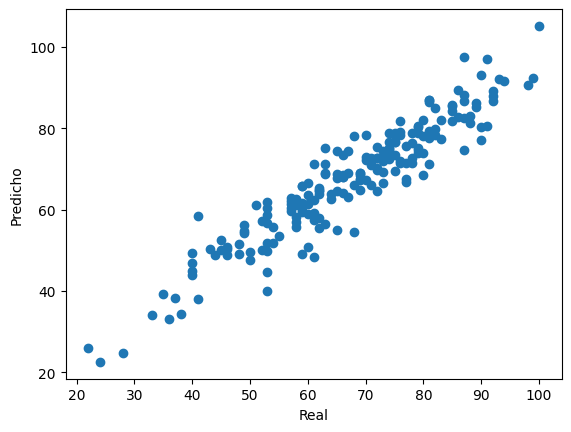

In [19]:
plt.scatter(y_test, y_pred)
plt.xlabel('Real')
plt.ylabel('Predicho')

<Axes: xlabel='math_score'>

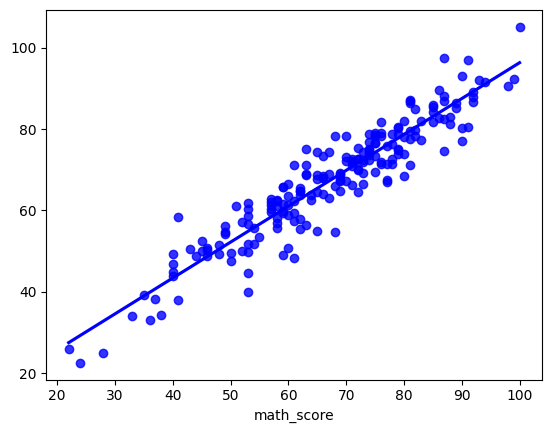

In [20]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='b')

### Diferencia entre valores reales y predichos

In [21]:
pred_df = pd.DataFrame({'Valor real':y_test, 'Valor predicho':y_pred, 'Diferencia':y_test - y_pred})
pred_df

,Valor real,Valor predicho,Diferencia
131,53,39.87500,13.12500
203,57,62.06250,-5.06250
50,53,61.84375,-8.84375
585,65,68.81250,-3.81250
138,59,59.90625,-0.90625
...,...,...,...
79,62,64.71875,-2.71875
177,71,66.15625,4.84375
657,69,68.93750,0.06250
210,80,78.00000,2.00000
